In [164]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
sys.path.append('..')

from sbi import simulator, model

In [165]:
theta_samples, x_samples = simulator.load(path = '../data', dataloader = False)

sim = simulator.Simulator()
#sim(n_train = 50_000, outpath='../data')
plx, e_plx, distance = sim.plxdata[:,0], sim.plxdata[:,1], sim.plxdata[:,2]

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


INFO: Query finished. [astroquery.utils.tap.core]


In [166]:
max(distance)

795.2568359375

In [167]:
def log_prior(dist):
    L = 350
    if (1 < dist < 2000):
        return np.log(dist**2 / (2*L**3)) - dist / L
    else:
        return np.inf

def log_likelihood(dist, plx, e_plx, prior = True):
    likelihood = -0.5*(np.log(e_plx) + ((1000/dist) - plx)**2/e_plx)
    prior = -log_prior(dist)
    return likelihood + prior if prior else likelihood

100%|██████████| 5000/5000 [00:13<00:00, 376.30it/s]


427.394287109375 452.0451120238056


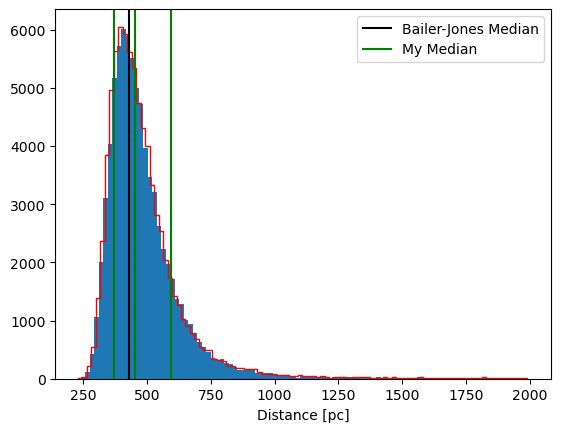

In [168]:
import emcee
import corner

i = np.random.randint(0, len(distance))

# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_prior = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(plx[i], e_plx[i], True))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_prior.run_mcmc(pos, 5000, progress=True);

# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_naive = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(plx[i], e_plx[i], False))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_naive.run_mcmc(pos, 5000, progress=True);

chain_prior=sampler_prior.get_chain(flat=True)
plt.hist(chain_prior[1000:], bins = 100)
chain_naive=sampler_naive.get_chain(flat=True)
plt.hist(chain_naive[1000:], bins = 100, histtype='step', color='red')
plt.axvline(distance[i], label="Bailer-Jones Median", c = 'k')
plt.axvline(np.percentile(chain_prior, 50), label="My Median", c = 'green')
plt.axvline(np.percentile(chain_prior, 84), c = 'green')
plt.axvline(np.percentile(chain_prior, 16), c = 'green')
plt.xlabel('Distance [pc]')
plt.legend()
print(distance[i], np.median(chain_prior))

In [169]:
torch.mean(theta_samples, axis=0)

tensor([4.0948e+04, 2.0439e+02, 1.4474e-02])

In [170]:
import corner

theta_test = np.array([17000, 100, 0.001])
x_test = sim.forward_noisy(*theta_test)
x_test_norm = (torch.Tensor(x_test) - x_samples.mean()) / x_samples.std()

npereader = model.load_model_from_path('../test_weights/test')
context = npereader.featurizer(x_test_norm).unsqueeze(0)
samples_test = npereader.flow.sample(num_samples=10000, context=context) * theta_samples.std(dim=0) + theta_samples.mean(dim=0)

In [171]:
# Sampling with `emcee`
ndim, nwalkers = 1, 16
sampler_prior = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x_test[0], x_test[1], True))
# Initialize the walkers
theta_guess = np.random.uniform(low=(1), high=(2000), size=(nwalkers, ndim))
pos = theta_guess + np.random.randn(nwalkers, ndim)
sampler_prior.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:10<00:00, 470.64it/s]


In [172]:
np.median(sampler_prior.get_chain(flat=True))

99.93796206503649

True parameters:
temperature = 17000.0 K 
distance = 100.0 pc 
radius = 0.10975 r_earth


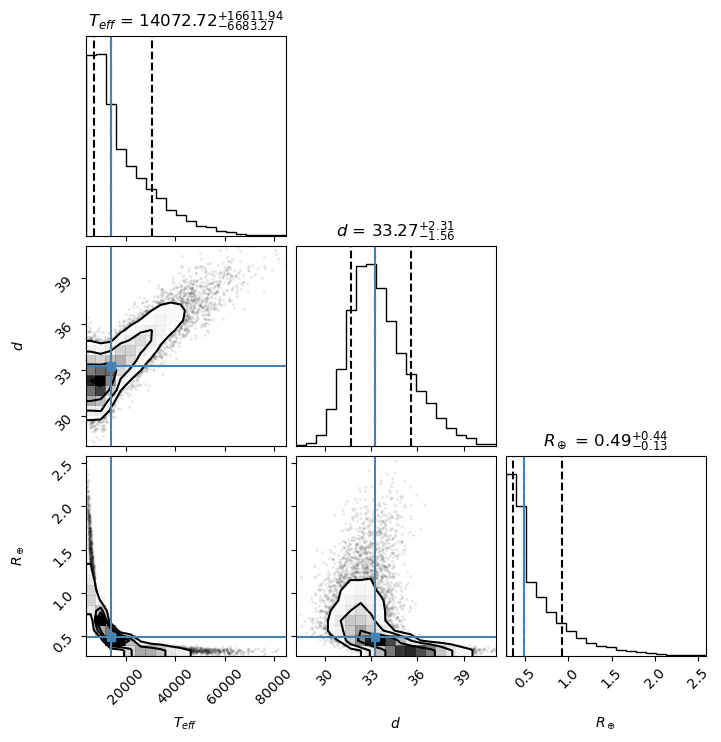

In [173]:
labels = [r"$T_{eff}$", r"$d$", r"$R_\oplus$"]
best_est = np.zeros((len(labels)))
unc = []

temp_chain = samples_test[0].detach().numpy()
temp_chain[:, 2] *= 109.075

for i in range(len(labels)):
    mcmc = np.percentile(temp_chain[:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

corner.corner(temp_chain, labels=labels, truths=best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.2f', title_kwargs={"fontsize": 12});
print(f"True parameters:\ntemperature = {theta_test[0]} K \ndistance = {theta_test[1]} pc \nradius = {theta_test[2]*109.75} r_earth")
plt.show()